In [1]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

def generate_data(n_points=10, eps=0.1, seed=None):
    if seed:
        np.random.seed(seed)
    if n_points == None:
        X = np.linspace(-2.2, 3.2, 1000)
        n_points = 1000
    else:
        X = np.random.uniform(low=-2, high=3, size=n_points)
        np.sort(X)
    y = X**3 - 2 * X ** 2 + 1.5 ** X + 5 + eps * np.random.normal(size=n_points)
    return X, y

def fit(X, y, style="linear"):
    model = LinearRegression(fit_intercept=True)
    feat = np.c_[X]
    
    if style == "linear":
        model.fit(feat, y)
        return model
    elif style == "poly_2":
        degree = 2
    elif style == "poly_3":
         degree = 3
    elif style == "poly_10":
        degree = 10
    pipeline = make_pipeline(PolynomialFeatures(degree=degree), 
                             LinearRegression())
    pipeline.fit(feat, y)
    return pipeline
        
def plot_fit(X, y, style="linear"):
    model = fit(np.c_[X], y, style)
    X_lin = np.linspace(-2.2, 3.2, 1000)
    y_lin = model.predict(np.c_[X_lin])
    
    plt.plot(X_lin, y_lin, label="Fit", alpha=0.8, ls="--", color="blue", lw=3)
    
    return model

def plot_rmse(X, y, model):
    y_pred = model.predict(np.c_[X])
    ax = plt.gca()
    mse = mean_squared_error(y, y_pred)
    for i in range(X.shape[0]):
        plt.annotate("", xy=(X[i], y[i]), xytext=(X[i], y_pred[i]),
                    arrowprops={'arrowstyle': '-', 'color':'red', 'ls': '--'})
    plt.text(0.05, 0.95, fontsize=14, s=f"MSE: {round(mse, 2)}", transform=ax.transAxes)
        
def plot_validation_samples(n_samples, eps, seed, model):
    X_val, y_val = generate_data(n_points=n_samples, eps=eps, seed=seed)
    
    plt.scatter(X_val, y_val, s=120, alpha=0.8, color="green", ec="k")
    
    if model:
        ax = plt.gca()
        val_mse = mean_squared_error(y_val, model.predict(np.c_[X_val]))
        plt.text(0.05, 0.9, fontsize=14, s=f"Val MSE: {round(val_mse, 2)}", transform=ax.transAxes)

    
def plot(n_points=10, eps=0.1, show_th=True, seed=None, show_xy=False, 
         fit=None, rmse=True, validation_samples=None, 
         title=None
        ):
    fig = plt.figure(figsize=(14, 8))
    if show_th:
        X_th, y_th = generate_data(n_points=None, eps=0, seed=seed)
        plt.plot(X_th, y_th, color="gray", ls="--", lw=3)
    X, y = generate_data(n_points=n_points, eps=eps, seed=seed)
    plt.scatter(X, y, s=100, alpha=0.8, ec="k")
    if show_xy:
        plt.xlabel("$X$", fontdict={'size': 20})
        plt.ylabel("$y$", fontdict={'size': 20})
    plt.tick_params(which='both', axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.xlim(-2.3, 3.3)
    plt.ylim(-15, 20)
    
    model = None
    if fit and fit != '':
        model = plot_fit(X, y, style=fit)
        
        if rmse:
            plot_rmse(X, y, model)
            
    if validation_samples:
        plot_validation_samples(validation_samples, eps=eps, seed=seed+1, model=model)
        
    if title:
        plt.title(title)
    
def make_plot(style="simple", n_points=10, seed=None):
    if style == "simple":
        plot(n_points=n_points, eps=2, show_th=True, seed=seed)
    elif style == "only_data":
        plot(n_points=n_points, eps=2, show_th=False, seed=seed)
    elif style == "center":
        plot(n_points=n_points, eps=2, show_th=False, seed=5)
    elif style == "xy":
        plot(n_points=n_points, eps=2, show_th=False, seed=5, show_xy=True)
        

# Create the plot dashboard
num_samples = widgets.Dropdown(options=[
    ('5 samples', 5),
    ('10 samples', 10), ('50 samples', 50), ('100 samples', 100), ('1000 samples', 1000)])
plot_style = widgets.Dropdown(options=[('Plain', 'plain'), ('Regression', 'regression'), ('Clustering', 'clustering')])
show_th = widgets.Checkbox(value=False, description="Show Theoretical Curve", indent=False)
noise = widgets.Dropdown(options=[('Low noise', 0.5), ('Medium noise', 2), ('High noise', 10)], value=2)
fitting = widgets.Dropdown(options=[
    ('No fit', ''),
    ('Linear', 'linear'),
    ('Polynomial 2', 'poly_2'),
    ('Polynomial 3', 'poly_3'),
    ('Polynomial 10', 'poly_10')
])
show_rmse = widgets.Checkbox(value=False, description="Show MSE", indent=False)
show_val = widgets.Checkbox(value=False, description="Show Validation set", indent=False)

plot_output = widgets.Output()
plot_output.layout.height = '550px'
plot_output.layout.width = '100%'


def change_handler(change):
    plot_handler(num_samples.value, plot_style.value, show_th.value, 
                 noise.value, fitting.value, show_rmse.value, show_val.value)
    
num_samples.observe(change_handler, names='value')
plot_style.observe(change_handler, names='value')
show_th.observe(change_handler, names="value")
noise.observe(change_handler, names='value')
fitting.observe(change_handler, names='value')
show_rmse.observe(change_handler, names='value')
show_val.observe(change_handler, names='value')
    
def plot_handler(n_points, style, show_th, noise, fitting, rmse, val):
    plot_output.clear_output()
    if val:
        val_sam = 10
    else:
        val_sam = None
    with plot_output:
        show_xy = style == 'regression'
        plot(n_points=n_points, eps=noise, show_th=show_th, seed=5, 
             show_xy=show_xy, fit=fitting, rmse=rmse, validation_samples=val_sam)
        plt.show()

checks = widgets.HBox([show_th, show_rmse, show_val])
selects = widgets.HBox([num_samples, noise, fitting])
controls = widgets.VBox([selects, checks])

dashboard = widgets.VBox([controls, plot_output])
change_handler(None)


## Talk plan

1. What is ML?

    1. A combination of methodology and a collection of algorithms that try to minimize a function by using data.
    
    2. Three general categories of ML algorithms: 
    
        1. Supervised Learning (Classification / Regression)
        2. Unsupervised Learning (Clustering / Anomaly detection / Dimensionality Reduction / ...)
        3. Reinforcement Learning (Playing Games / Autonomous Driving / ...)
        
    3. The methodology is in place to try to avoid common problems arising in ML. 
    
        1. Overfitting and Underfitting: imagine the process of fitting a (polynomial) linear regression model. 
    
    

# Introduction to Machine Learning with scikit-learn

### Or why Scikit-Learn is great!

# About me

<center><img src="images/family.jpg" width="100%" height="100%"></center>

* Trained as a physicist

* PhD in computational science

* Work @ <a href="http://schmiede.one">schmiede.one</a> as a data scientist

<img src="images/sellnow.png">

## Some disclaimers

1. Not a computer scientist

2. Don't have a lot of experience with sklearn - teach to learn

3. Keep it very high level - there are a lot of important details in every step of the way that I skip.

# What is Machine Learning?

> A **methodology** and a collection of **algorithms** designed to discover meaningful **patterns** in raw data.

Regression

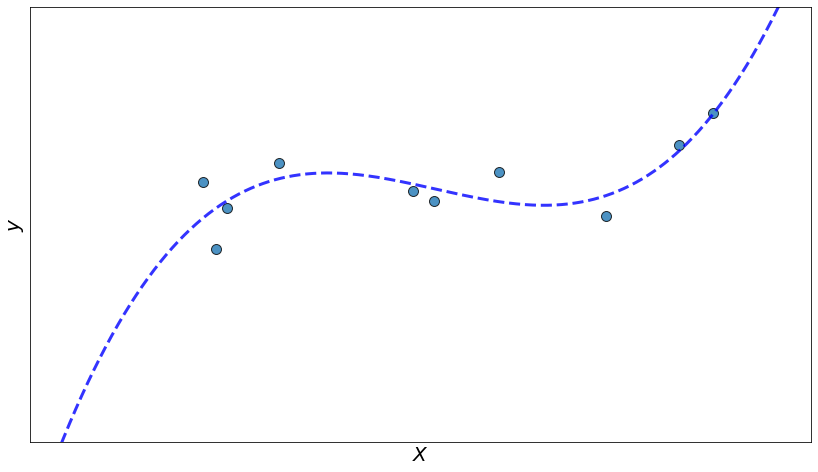

In [3]:
from IPython.display import display_html
display_html("<h4>Regression</h4>", raw=True)
plot(n_points=10, eps=2, show_th=False, show_xy=True, seed=5, fit="poly_3", rmse=False)
plt.show()

#### Clustering
<img src="images/clusters.png">

#### Classification
<img src="images/classification.jpg"/>

# How Machine Learning Works?

1. Collect $N$ data points $X, y$

2. Define a model:

$$ y \sim b + a_1 X_1 + a_2 X_2 + \cdots + \epsilon $$

3. *Fit* the model by finding parameters $a_1, \ldots, a_n, b$ that minimize the *loss function*:

$$ L = \sum\limits_{i=1}^N \left( y_i - \hat{y}_i \right)^2 $$

4. Evaluate the model and repeat.

<center><h1>What can go wrong?</h1></center>

# Problems you ~might~ will face

## Not enough data / too noisy data

In [4]:
display(dashboard)

## Underfitting (high bias)

In [5]:
display(dashboard)

## Overfitting (high variance)

In [6]:
display(dashboard)

1. Not enough data
2. Noisy data
3. Underfitting
4. Overfitting

#### Potential problems

1. Not enough data / too noisy data.

2. Underfitting - model not rich enough to capture the patterns in the data.

3. Overfitting - model fits the data "too well" - does not capture general pattern - captures the details.

#### Possible solutions

1. Collect more / different data.

2. Use a more advanced model.

3. Use validation set, increase data points, regularization.

<center><img src="images/the_ml_process.svg" height="90%" style="max-height: 90%;"></center>

<center><img src="images/Scikit_learn_logo_small.svg"></center>

# How I got to know Scikit-learn

In [7]:
# Need to run PCA on some high dimensional data

from sklearn.decomposition import PCA

def perform_PCA(data, components=2):
    pca = PCA(n_components=components)
    pca.fit(data)
    return pca.components_

# Why is PCA a class?
# Why do I need to call fit on the class?
# Why is the main output "hidden" in an attribute with undrscore after the name?

In [8]:
# Need to run PCA on some high dimensional data

from sklearn.decomposition import PCA

def perform_PCA(data, components=2):
    pca = PCA(n_components=components)
    pca.fit(data)
    return pca.components_, pca.explained_variance_

# Why is PCA a class?
# Why do I need to call fit on the class?
# Why is the main output "hidden" in an attribute with undrscore after the name?

<center><img src="images/scikit-book.jpg" style="height: 600px;"></center>

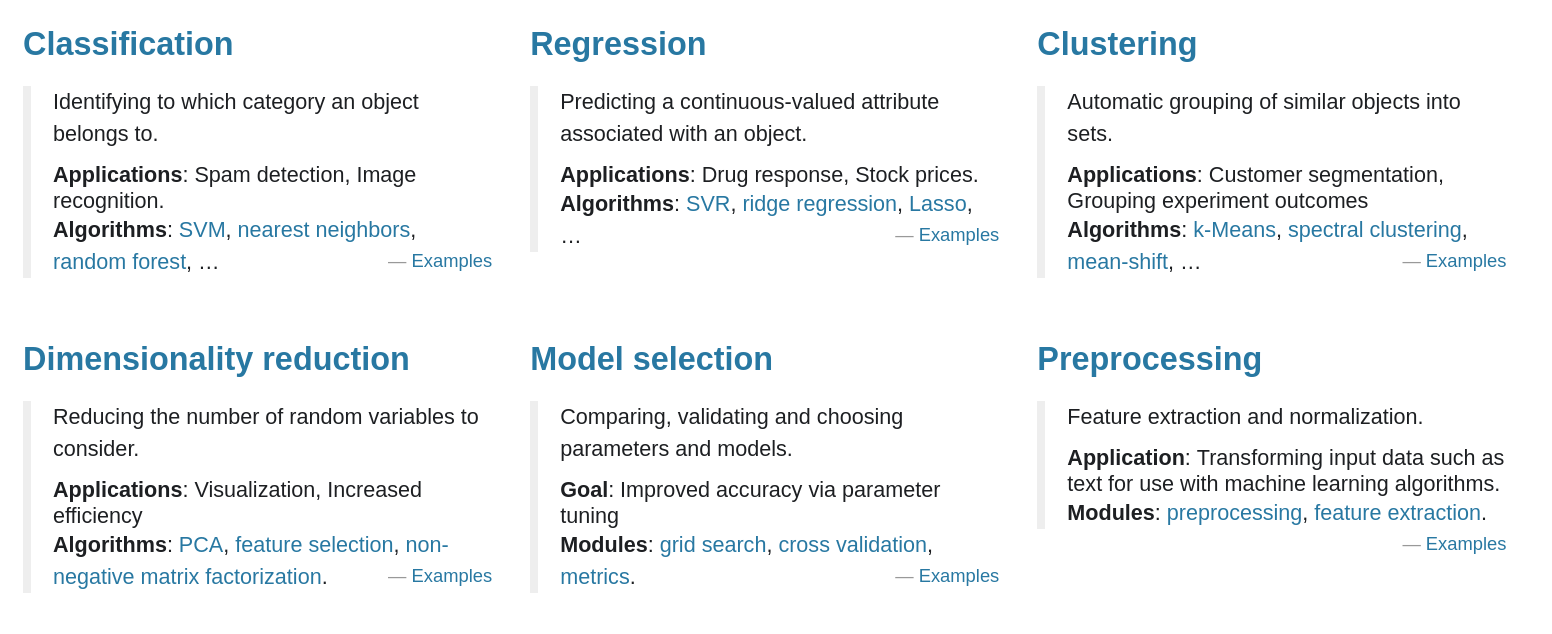

#### Design Principles

1. **Consistency** - All objects follow a consistent and predictable API.
2. **Estimators** - An object with `fit()` method - estimates params from data.
3. **Transformers** - An object with `transform()` and `fit_transform()` methods.
4. **Predictors** - An object with `predict()` and `score()` methods.


#### Design Principles

5. **Inspection** - All hyperparameters are accessible via public instance variables.
6. **Nonproliferation of classes** - All data is numpy arrays or scipy sparse matrices.
7. **Composability** - Algorithms can be easily composed in pipelines.

<small>Based on: https://medium.com/@madhav.mishra/scikit-learn-design-principles-bae32277bb2d</small>

In [9]:
# Simple Example - Linear regression with a linear feature set

X_train, y_train = generate_data(n_points=100, eps=2)
X_val, y_val = generate_data(n_points=10, eps=2)

display(X_val, y_val)

array([ 0.19084446, -1.36977073, -0.9848401 ,  2.20771371, -0.13783773,
       -0.90659135,  2.23066411,  0.87687333,  1.16858239,  2.44464272])

array([4.02336845, 1.0650189 , 2.82417235, 7.98013818, 7.72524851,
       4.53913937, 9.61757767, 3.26028493, 4.24971282, 6.94405026])

In [10]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(np.c_[X_train], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [11]:
# Model parameters (coef_ - slope, intercept_ - intercept)
print(f"Model coef_:{model.coef_}")
print(f"Model intercept_: {model.intercept_}")

# Model score on validation set
score = model.score(np.c_[X_val], y_val)
print(f"Model R^2 score: {score}")

Model coef_:[3.3528395]
Model intercept_: 3.1957534870551463
Model R^2 score: -0.5638822022782888


In [12]:
# Let's do the same with polynomial fit
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(degree=3)
pf.fit(np.c_[X_train])
X_train_poly = pf.transform(np.c_[X_train])

model = LinearRegression()
model.fit(X_train_poly, y_train)

# Model parameters (coef_ - slope, intercept_ - intercept)
print(f"Model coef_:{model.coef_}")
print(f"Model intercept_: {model.intercept_}")

# Model score on validation set
X_val_poly = pf.transform(np.c_[X_val])
score = model.score(X_val_poly, y_val)
print(f"Model R^2 score: {score}")

Model coef_:[ 0.         -0.0714656  -2.08506017  1.12372006]
Model intercept_: 6.33111515274098
Model R^2 score: 0.5870327805554643


In [19]:
# Now combine this to create a pipeline estimator that does everything at once:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    PolynomialFeatures(degree=2),
    LinearRegression()
)

pipeline.fit(np.c_[X_train], y_train)
pipeline.score(np.c_[X_val], y_val)

-0.5766103789416397

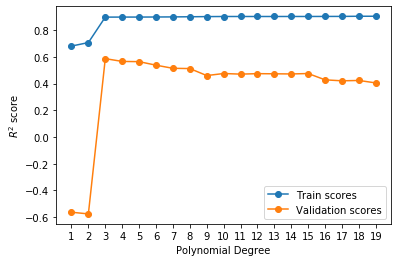

In [27]:
# Lets see now how the scores for the models change as a function of degree
val_scores = []
train_scores = []
degrees = range(1, 20)
for degree in degrees:
    pipeline = make_pipeline(
        PolynomialFeatures(degree=degree),
        LinearRegression()
    )
    pipeline.fit(np.c_[X_train], y_train)
    train_scores.append(pipeline.score(np.c_[X_train], y_train))
    val_scores.append(pipeline.score(np.c_[X_val], y_val))
    
plt.plot(degrees, train_scores, '-o', label="Train scores")
plt.plot(degrees, val_scores, '-o', label="Validation scores")
plt.xticks(degrees)
plt.xlabel("Polynomial Degree")
plt.ylabel("$R^2$ score")
plt.legend()
plt.show()

#### Model Zoo